In [1]:
%matplotlib inline

import zipfile
import io
import csv
import math
import time

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

In [263]:
#Load Data set
with zipfile.ZipFile('sarcos_inv.zip') as zf:
    with zf.open('sarcos_inv.csv') as f:
        sf = io.TextIOWrapper(f)
        reader = csv.reader(sf)
        data_raw = []
        for row in reader:
            data_raw.append([float(v) for v in row])
        data_raw = np.array(data_raw)
        
def normalise_data(x_unnormalised):
    a = 1/np.std(x_unnormalised,axis=0)
    b = -np.mean(x_unnormalised,axis=0)
    x_normalised = a*(x_unnormalised + b)
    return x_normalised, a, b

def unnormalise_data(x_normalised, a, b):
    x_unnormalised = x_normalised/a - b
    return x_unnormalised

#Split into Training and Testing Sets
total_count = data_raw.shape[0]

split = int(total_count * 0.6)

# Shuffle the data to avoid any ordering bias..
np.random.seed(0)
shuffle = np.random.permutation(total_count)

data = data_raw[shuffle]

train_data_unnormed = data[:split]
test_data_unnormed = data[split:]

train_data, norm_train_a, norm_train_b  = normalise_data(train_data_unnormed)
test_data, norm_test_a, norm_test_b  = normalise_data(test_data_unnormed)

assert(np.all(np.isclose(train_data_unnormed,unnormalise_data(train_data, norm_train_a, norm_train_b))))
assert(np.all(np.isclose(test_data_unnormed,unnormalise_data(test_data, norm_test_a, norm_test_b))))

print(test_data.shape[0])
print(train_data.shape[0])

17794
26690


In [77]:
 # K Nearest Neighbors
    
# calculates the Euclidean distance between x and y
def euDistance(x,y):
    distance = np.sum(np.square(x - y))
    return np.sqrt(distance)

 
def kNN(test,trainingSet,k):
    distances = []
    length = test.shape[0] - 1
    for i in range(trainingSet.shape[0]):
        dist = euDistance(test[:length], trainingSet[i,:length])
        distances.append((trainingSet[i,length], dist))
    dist = np.array(distances,dtype=np.dtype('float,float'))
    ind = np.argpartition(dist['f1'], k)[:k]
    distances = dist[ind]
    if 0.0 in distances['f1']:
    #Non Weighted Average
       return sum(i for i, _ in distances)/k
    else:
    # Weighted Average
        return sum(i/(j*j) for i, j in distances)/sum(1/(j*j) for _, j in distances)
    
    #return sum(i for i, _ in distances)/k

def least_squares_error(x, y):
    squared_error = np.sum(np.square(x-y))
    return squared_error

def run_kNN(train_data, test_data, k):
    
    index = train_data.shape[1] -1
    test_est = np.apply_along_axis( kNN, axis=1, arr=test_data[:] , trainingSet=train_data , k=k)
    
    return test_est , least_squares_error(test_est,test_data[:,index])

    
#print(test_data_unnormed[2,21])
#print(kNN(test_data_unnormed[2],train_data_unnormed,4))
    
#print(test_data[2,21])
#print(kNN(test_data[2],train_data,4))

#y_kNN = np.apply_along_axis( kNN, axis=1, arr=test_data , trainingSet=train_data , k=1)
kNN_est , kNN_error = run_kNN(train_data, test_data[:,:], 1)
print(kNN_error)


33.437817
32.4210105091
0.94934238789
0.915086024847


In [162]:
least_squares_error(y_kNN,test_data[:,21])

796.21553134483838

In [253]:
#Linear Regression

#Analytical Solution


def reg_lin_regression(x,y, delta = 0):
    
    #XX' + dI
    a = np.transpose(x).dot(x) + (delta * np.identity(x.shape[1]))
    #w* = (X'X +dI)^-1X'y
    w = (np.linalg.inv(a).dot(np.transpose(x))).dot(y)
    
    return w

def run_reg_lin_regression(train_data, test_data, delta = 0):
    # Builds and runs Regulized linear Regression
    index = train_data.shape[1]-1
    x = train_data[:,:index]
    y = train_data[:,index:]
    w_best = reg_lin_regression(x,y, delta)
    
    test_est = test_data[:,:index].dot(w_best)
    
    return test_est , least_squares_error(test_est,test_data[:,index:])


#b_new = reg_lin_regression(train_data[:,:21],train_data[:,21:])
#y_new = test_data[:,:21].dot(b_new)

#print("Linear Regression least Squares error = ", least_squares_error(y_new,test_data[:,21:]))


    

In [8]:
#Regression Forests
def calculate_variance(y):
    mean = np.nanmean(y)
    variance =  np.sum((y-mean)*(y-mean))
    return variance

def find_split(x, y, p_features):
    """Given a dataset and its target values, this finds the optimal combination
    of feature and split point that gives the maximum information gain."""
    
    # Need the starting entropy so we can measure improvement...
    start_variance = calculate_variance(y)
    
    # Best thus far, initialised to a dud that will be replaced immediately...
    best = {'infogain' : np.inf}
    
    # Loop every possible split of every dimension...
    idx = np.random.randint(x.shape[1], size=p_features)
    for i in idx:
        for split in np.unique(x[:,i].round(decimals=3)):
            
            # Find the indices for the data which pass/fail the feature split
            left_indices  = np.where(x[:,i]<=split)[0]
            right_indices = np.where(x[:,i]>split)[0]
            
            if left_indices.size == 0 or right_indices.size == 0:
                continue
            else:
                # Get the entropies of the split data sets 
                left_var = calculate_variance(y[left_indices])
                right_var = calculate_variance(y[right_indices])


                #infogain = start_variance - (left_var + right_var)
                infogain = left_var + right_var

                # **************************************************************** 5 marks

                if infogain < best['infogain']:
                    best = {'feature' : i,
                            'split' : split,
                            'infogain' : infogain, 
                            'left_indices' : left_indices,
                            'right_indices' : right_indices}
    return best
    
    
def build_tree(x, y, p_features, max_depth = np.inf):
    # Check if either of the stopping conditions have been reached. If so generate a leaf node...
    mean = np.nanmean(y)
    tol = 0.001
    if max_depth==1 or ((y<= mean + tol).all() and (y>= mean - tol).all()):
        # Generate a leaf node...
        return {'leaf' : True, 'result' : mean}
    
    else:
        move = find_split(x, y,p_features)
        
        if np.isinf(move['infogain']):
            return {'leaf' : True, 'result' :mean}
        else:
            left = build_tree(x[move['left_indices'],:], y[move['left_indices']],p_features , max_depth - 1)
            right = build_tree(x[move['right_indices'],:], y[move['right_indices']], p_features , max_depth - 1)

            return {'leaf' : False,
                    'feature' : move['feature'],
                    'split' : move['split'],
                    'infogain' : move['infogain'],
                    'left' : left,
                    'right' : right}

def build_forest(x,y, n_trees, p_features , set_size, max_depth = np.inf):
    
    forest = []
    if set_size > x.shape[0] or set_size <= 0:
        set_size = x.shape[0]
    
    
        if p_features > x.shape[1] or p_features <=0:
            p_features = x.shape[1]
        
    for _ in range(n_trees):
        idx = np.random.randint(x.shape[0], size=set_size)
        if len(x.shape) > 1:
            t = build_tree(x[idx,:],y[idx],p_features, max_depth)
        else:
            t = build_tree(x[idx],y[idx],p_features, max_depth)
        forest.append(t)
        
    return forest
        
def predict_tree(tree, samples):
    """Predicts for every entry of a data matrix."""
    ret = np.empty(samples.shape[0])
    indices = np.arange(samples.shape[0])
    
    def tranverse(node, indices):
        nonlocal samples
        nonlocal ret
        
        if node['leaf']:
            ret[indices] = node['result']
        
        else:
            going_left = samples[indices, node['feature']] <= node['split']
            left_indices = indices[going_left]
            right_indices = indices[np.logical_not(going_left)]
            
            if left_indices.shape[0] > 0:
                tranverse(node['left'], left_indices)
                
            if right_indices.shape[0] > 0:
                tranverse(node['right'], right_indices)
    
    tranverse(tree, indices)
    return ret

    
#forest_10 = build_forest(train_data[:,:21],train_data[:,21],20,5,int(train_data[:,:21].shape[0] * 0.25),20)




In [141]:
# Random Forest Prediction
def predict_one(tree, sample):
    """Does the prediction for a single data point"""
    if tree['leaf']:
        return tree['result']
    
    else:
        if sample[tree['feature']] <= tree['split']:
            return predict_one(tree['left'], sample)
        else:
            return predict_one(tree['right'], sample)


def predict_forest_1(forest, sample):
    rets = np.empty(len(forest))
    #Predict on trees
    for i in range(len(forest)):
        rets[i] = predict_one(forest[i], sample)
        
    #Average results
    rets = rets.sum()/len(forest)
    return rets

def predict_forest(forest, samples):
    rets = np.empty((samples.shape[0],len(forest)))
    #Predict on trees
    for i in range(len(forest)):
        rets[:,i] = predict_tree(forest[i], samples)
        
    #Average results
    rets = rets.sum(axis=1)/len(forest)
    error = least_squares_error(rets,samples[:,-1])

    return rets , error

def run_regression_forests(train_data, test_data, n_trees, p_features , set_size, max_depth):
    
    forest = build_forest(train_data[:,:-1],train_data[:,-1], n_trees, p_features , set_size, max_depth)
    prediction, error = predict_forest(forest,test_data[:,:-1])
    
    return prediction ,  error#least_squares_error(prediction,test_data[:,-1])

#forest_y = predict_forest(forest_10,test_data[:,:21])
#forest_y0 = predict_forest_1(forest_10,test_data[54,:21])
#print(forest_y)
#print(forest_y0)
#print(least_squares_error(forest_y,test_data[:,21]))



In [20]:
#Gassian Process

#Squared Exponential Kernal
def squaredExpKernel(xi,xj, sigma , l):
    

    diff = (xi - xj)
    return (sigma**2) * np.exp(-np.sum(diff**2)/(2*l**2))

def squaredExpKernel_Quick(xi,xj, sigma , l):
    

    #diff = (xi - xj)
    #print(diff)
    #diffs = np.expand_dims(xi/l, 1) - np.expand_dims(xj/l, 0)
    pairwise_dists = squareform(pdist(xi, 'sqeuclidean'))
    #return 
    return (sigma**2) * np.exp(-pairwise_dists/(2*l**2))

def rationalQuadraticKernel(xi,xj, alpha, sigma ,l):
    
    diff = (xi - xj)
    return (sigma**2) * (1 +np.sum(diff**2)/(2**alpha*(l**2)))**(-alpha)

def rationalQuadraticKernel_Quick(x, alpha, sigma ,l):
    
    pairwise_dists = squareform(pdist(x, 'sqeuclidean'))
    return (sigma**2) * (1 + pairwise_dists/(2**alpha*(l**2)))**(-alpha)




In [225]:

def gaussianProcessPredict_one(Kx_inv, train_x, train_y, predict_data, noise, kernel, *args, **kwargs):
    
    kpredict = kernel(predict_data, predict_data, *args, **kwargs)
    kT = np.array([kernel(train_x[i],predict_data ,*args,**kwargs) for i in range(train_x.shape[0])])
    
    mean = (kT.dot(Kx_inv)).dot(train_y) 
    cov = kpredict - (kT.dot(Kx_inv)).dot(np.transpose(kT))
    
    
    #print(mean)
    #print(cov)
    
    return mean , cov

def gaussianLogLikelihood(Kx, y, noise):
    
    N = Kx.shape[0]
    Kx_inv = np.linalg.inv(Kx)
    logp_y_x = (np.dot(y.T, Kx_inv).dot(y) + math.log(np.linalg.norm(Kx)) + N*math.log(2*math.pi))/(-2)
    
    return logp_y_x


#gaussianProcessPredict_one(cov,train_data[0:5000,:21],train_data[0:5000,21],test_data[5,:21], 0.1, squaredExpKernel, sigma =1, l =1)

#gaussianLogLikelihood(cov, train_data[0:5000,21],0.1)


def GausianHypapamtersOptimization_SE(train_x , train_y):

    def calcLoglikelihood(sigma, l, noise):
        Kx = squaredExpKernel_Quick(train_x,train_x, sigma,l) + (noise * np.identity(train_x.shape[0]))
        return gaussianLogLikelihood(Kx, train_y, noise)
    
    sigmas = np.linspace(0.5,30,100)
    ls = np.linspace(0.01,1.5 ,100)
    noises = np.linspace(0.5,10,100)
    
    best_s = 1
    best_l = 1
    best_n = 0
    
    fig=plt.figure(figsize=(9, 8))
    
    ll_l = [calcLoglikelihood(best_s, x, best_n) for x in ls]
    plt.plot(ls,ll_l)
    
    best_l = ls[np.argmax(ll_l)]
    
    ll_s = [calcLoglikelihood(x, best_l, best_n) for x in sigmas]
    plt.plot(sigmas,ll_s)
    
    best_s = sigmas[np.argmax(ll_s)]
    
    ll_n = [calcLoglikelihood(best_s, best_l, x) for x in noises]
    plt.plot(noises,ll_n)
    
    best_n = noises[np.argmax(ll_n)]
    
    
    return best_s, best_l ,best_n

def GausianHypapamtersOptimization_RQ(train_x , train_y):

    def calcLoglikelihood(alpha,sigma, l, noise):
        Kx = rationalQuadraticKernel_Quick(train_x,alpha,sigma,l) + (noise * np.identity(train_x.shape[0]))
        return gaussianLogLikelihood(Kx, train_y, noise)
    
    sigmas = np.linspace(0.5,10,100)
    ls = np.linspace(0.01,5 ,100)
    noises = np.linspace(0.5,10,50)
    alphas = np.linspace(0.5,5,50)
    
    best_a = 1
    best_s = 1
    best_l = 1
    best_n = 1
    
    fig=plt.figure(figsize=(9, 8))
    
    ll_l = [calcLoglikelihood(best_a, best_s, x, best_n) for x in ls]
    plt.plot(ls,ll_l)
    
    best_l = ls[np.argmax(ll_l)]
    
    ll_s = [calcLoglikelihood(best_a,x, best_l, best_n) for x in sigmas]
    plt.plot(sigmas,ll_s)
    
    best_s = sigmas[np.argmax(ll_s)]
    
    ll_a = [calcLoglikelihood(x,best_s, best_l, x) for x in alphas]
    plt.plot(alphas,ll_a)
    
    best_a = alphas[np.argmax(ll_a)]
    
    ll_n = [calcLoglikelihood(best_a,best_s, best_l, x) for x in noises]
    plt.plot(noises,ll_n)
    
    best_n = noises[np.argmax(ll_n)]
    
    return best_a, best_s, best_l, best_n



26.4242424242 1.35263157895 10.0
2.24489795918 10.0 3.57070707071 10.0


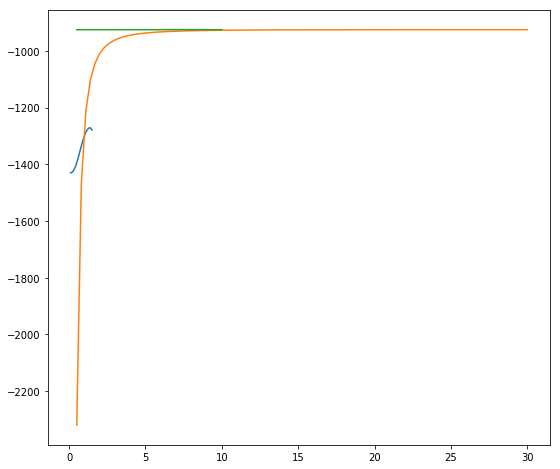

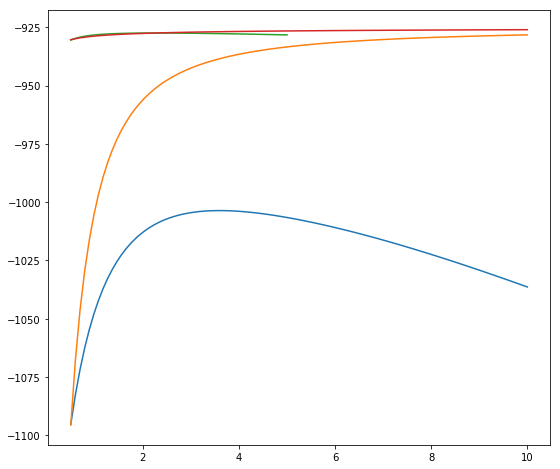

In [115]:
sigma_best_SE , l_best_SE, n_best_SQ= GausianHypapamtersOptimization_SE(train_data[0:1000,:21] , train_data[0:1000,21])
alpha_best_RQ, sigma_best_RQ , l_best_RQ, n_best_RQ = GausianHypapamtersOptimization_RQ(train_data[0:1000,:21] , train_data[0:1000,21])

print(sigma_best_SE,l_best_SE,n_best_SQ)
print(alpha_best_RQ, sigma_best_RQ,l_best_RQ,n_best_RQ)

In [116]:

cov_SE = squaredExpKernel_Quick(train_data[0:10000,:21],train_data[0:10000,:21], sigma_best_SE, l_best_SE)
cov_RQ = rationalQuadraticKernel_Quick(train_data[0:10000,:21],alpha_best_RQ, sigma_best_RQ, l_best_RQ)


In [ ]:
def GuassianProccessPredict(Kx, train_x, train_y, predict_data, noise, kernel, *args, **kwargs):
    y_pred = np.empty((predict_data.shape[0],2))
    
    Kx_inv = np.linalg.inv(Kx + (noise * np.identity(Kx.shape[0])))
    for i in range(predict_data.shape[0]):
        mean, var = gaussianProcessPredict_one(Kx_inv, train_x, train_y, predict_data[i,:], noise, kernel, *args, **kwargs)
        y_pred[i,0] = mean
        y_pred[i,1] = var
    
    return y_pred

   
guassian_y_SE = GuassianProccessPredict(cov_SE, train_data[0:10000,:21],train_data[0:10000,21], test_data[:,:21] , n_best_SE, squaredExpKernel , sigma_best_SE, l_best_SE )
guassian_y_RQ = GuassianProccessPredict(cov_RQ, train_data[0:10000,:21],train_data[0:10000,21], test_data[:,:21] , n_nest_RQ, rationalQuadraticKernel ,alpha_best_RQ, sigma_best_RQ, l_best_RQ )



In [161]:

def mean_error(x,y):
    error = np.mean(np.sqrt((x-y)**2))
    return error

error = least_squares_error(guassian_y,test_data[:,21])

print(error)


641.883438542


In [246]:
# Validation

def nfold_cross_validation(data , n, function , *args, **kwargs):
    if n < 2:
        print('n is too small')
    else:
    
        data_split = int(data.shape[0]/n)
        error = []
        for i in range(n):
            validation = data[i*data_split:(i+1)*data_split]
            train_l = data[:i*data_split]
            train_r = data[(i+1)*data_split:]
            train = np.concatenate((train_l,train_r))
            _, e = function(train, validation, *args , **kwargs)
            error.append(e)
          
        return sum(error)/len(error)
           
def optimize_KNN(train_data, min_k = 1, max_k = 20):
    
    best_k = 0
    best_error = np.inf
    errors = []
    for k in range(min_k,max_k):
        error = nfold_cross_validation(train_data,10, run_kNN, k=k)
        if error <= best_error:
            print("New best k = ",k,", With Error ", error)
            best_k = k
            best_error = error
        errors.append(error)
        
    return best_k , best_error
    
def optimize_Regression_Forest(train_data):
    
    #Only optimise depth and number of trees and fix number of feature and set size
    best_depth = 0
    best_error = np.inf
    errors = []
    for d in range(5,30):
        error = nfold_cross_validation(train_data,10, run_regression_forests,n_trees = 20, p_features = int(np.sqrt(train_data.shape[1])) , set_size =int(0.25 * train_data.shape[0]) , max_depth = d )
        if error <= best_error:
            print("New best Max Depth ",d," With error ", error)
            best_depth = d
            best_error = error
        errors.append(error)
     
    split = int(0.9 * train_data.shape[0])
    
    forest_100 = build_forest(train_data[:split,:-1],train_data[:split,-1], 100, int(np.sqrt(train_data.shape[1])) , int(0.25 * train_data.shape[0]) ,  int(best_depth/2))

    OOB = []   
    best_error = np.inf
    best_Ntrees = 1
    for n in range(10,100):
        predict, error = predict_forest(forest_100[:n], train_data[split:,:-1])
        if error <= best_error:
            print("New best Ntrees ",n," With error ", error)
            best_Ntrees = n
            best_error = error
        OOB.append(error)
    
    
    best_size = 0
    best_error = np.inf
    for s in range(15,75,10):
        size = int(s*0.01*train_data.shape[0])
        error = nfold_cross_validation(train_data,10, run_regression_forests,n_trees = best_Ntrees, p_features = int(np.sqrt(train_data.shape[1])) , set_size =size , max_depth = int(best_depth/2) )
        if error <= best_error:
            print("New best Max size ",size," With error ", error)
            best_size = s*0.01
            best_error = error
        errors.append(error)
    
    return best_depth , best_Ntrees , best_size
                       
#best_k, Knn_errors = optimise_KNN(train_data[0:10000,:])
#best_depth, best_NTrees = optimise_Regression_Forest(train_data[0:10000,:])

In [274]:
# Problem Solutions

KNN_1 , kNN_1_error = run_kNN(train_data, test_data[0:5000,:], 1)
KNN_4 , kNN_4_error = run_kNN(train_data, test_data[0:5000,:], 4)
print("KNN least squares error with k=1 :",kNN_1_error)
print("KNN least squares error with k=4 :",kNN_4_error)

linreg_predict, linreg_error = run_reg_lin_regression(train_data, test_data[0:5000,:])
print("Linear Regression least Squares error = ", linreg_error)

#Forest with 25 trees, 5 feaures, 25% of the data, depth of 25
forest_25 = build_forest(train_data[:,:21],train_data[:,21],25,5,int(train_data[:,:21].shape[0] * 0.25),25) 
#Forest with 50 trees, 5 feaures, 15% of the data, depth of 30
forest_50 = build_forest(train_data[:,:21],train_data[:,21],50,5,int(train_data[:,:21].shape[0] * 0.15),30) 
forest25_predict , forest25_error = predict_forest(forest_25,test_data[0:5000,:])
forest50_predict , forest50_error = predict_forest(forest_50,test_data[0:5000,:])

print("Regression Forests for forest_25 least squares error:",forest25_error)
print("Regression Forests for forest_50 least squares error:",forest50_error)

guassian_y_SE = GuassianProccessPredict(cov_SE, train_data[0:10000,:21],train_data[0:10000,21], test_data[0:5000,:21] , 1, squaredExpKernel , sigma_best_SE, l_best_SE )
guassian_y_RQ = GuassianProccessPredict(cov_RQ, train_data[0:10000,:21],train_data[0:10000,21], test_data[0:5000,:21] , 1, rationalQuadraticKernel ,alpha_best_RQ, sigma_best_RQ, l_best_RQ )
print("Gaussian Process with SE Kernel has least squares error:",least_squares_error(guassian_y_SE[:,0],test_data[0:5000,21]))
print("Gaussian Process with RQ Kernel has least squares error:",least_squares_error(guassian_y_RQ[:,0],test_data[0:5000,21]))

KNN least squares error with k=1 : 216.055619574
KNN least squares error with k=4 : 132.45124474
Linear Regression least Squares error =  350.527926557
Regression Forests for forest_25 least squares error: 318.952651868
Regression Forests for forest_50 least squares error: 376.661717618
Gaussian Process with SE Kernel has least squares error: 247.01622645
Gaussian Process with RQ Kernel has least squares error: 76.0469247243


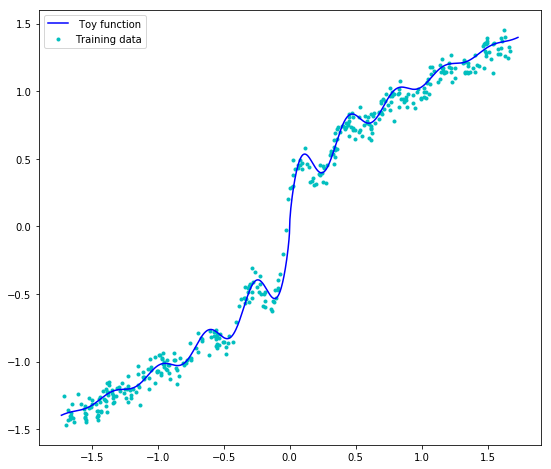

In [153]:
# Toy Problem

# Take values from y = (0.98^(x)*2sin(x/5)+x^(1/2))
def toy_function(x_data,n=0):
    y = []
    for x in x_data:
        noise = np.random.normal(0,n)
        a = 0.98**(abs(x))
        b = 2*math.sin(x/5)
        c = math.pow(abs(x),float(1)/2) * (1,-1)[x<0]
        y.append((a*b +c) + noise)
    
    return y
        
np.random.seed(13)

x_pred = np.linspace(-150, 150, 1000)
y_pred = toy_function(x_pred)

x = np.random.uniform(-150,150, 500)
y = toy_function(x,n=0.5)

toy_split = int(0.8 * 500)

x_pred_norm, _,_ = normalise_data(x_pred)
y_pred_norm, _,_ = normalise_data(y_pred)


normx, ax, _ =normalise_data(x)
normy, ay, _ =normalise_data(y)


train_x = normx[:toy_split]

train_y = normy[:toy_split]
train_data_toy = np.column_stack((train_x,train_y))

test_x = normx[toy_split:]
test_y = normy[toy_split:]
test_data_toy = np.column_stack((test_x,test_y))

fig=plt.figure(figsize=(9, 8))
plt.scatter(train_x,train_y,c='c',marker='.', label='Training data' )
plt.plot(x_pred_norm, y_pred_norm, c='b', label = ' Toy Function')
plt.legend(loc='upper left')
plt.show()


In [244]:
#Toy Problem Optimization

toy_bestK, error = optimize_KNN(train_data_toy)
toy_best_Depth , toy_best_ntrees, best_size = optimize_Regression_Forest(train_data_toy)

toy_sigma_SE , lot_l_SE,_= GausianHypapamtersOptimization_SE(train_data_toy[:,:-1] , train_data_toy[:,-1])
toy_alpha_RQ, toy_sigma_RQ , toy_l_RQ, _ = GausianHypapamtersOptimization_RQ(train_data_toy[:,:-1] , train_data_toy[:,-1])


New best Max Depth  5  With error  3.05805212419
New best Max Depth  6  With error  2.99187917926
New best Ntrees  10  With error  2.33409629278
New best Max size  60  With error  2.92999625573


KNN Method Before Optimization, Test Error =  0.641128075142
KNN Method After Optimization, Test Error =  0.470344865295


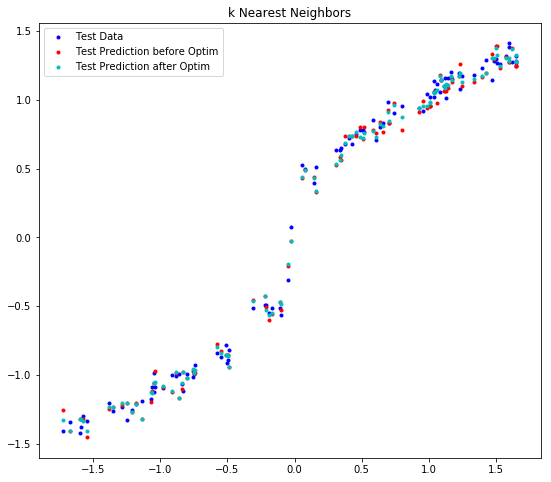

Linear Regression, Test Error =  5.19168045053


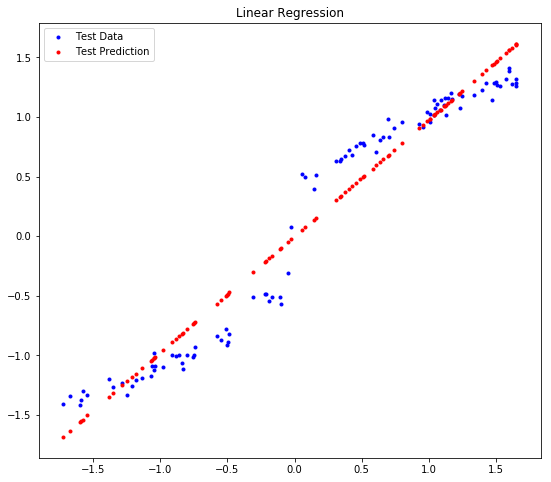

Regression Forest Method Before Optimization, Test Error =  4.42656168398
Regression Forest Method After Optimization, Test Error =  4.02630163178


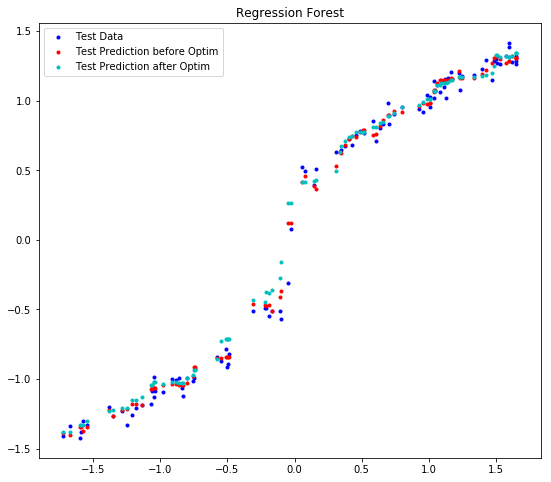

Gaussian Process with SE Kernel, Test Error =  0.36026995773


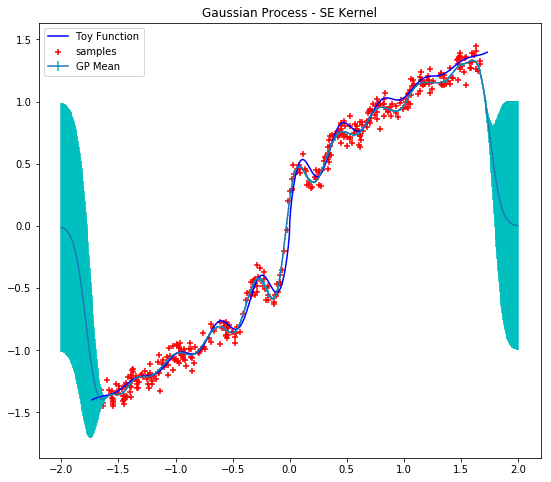

Gaussian Process with RQ Kernel, Test Error =  0.318049956704


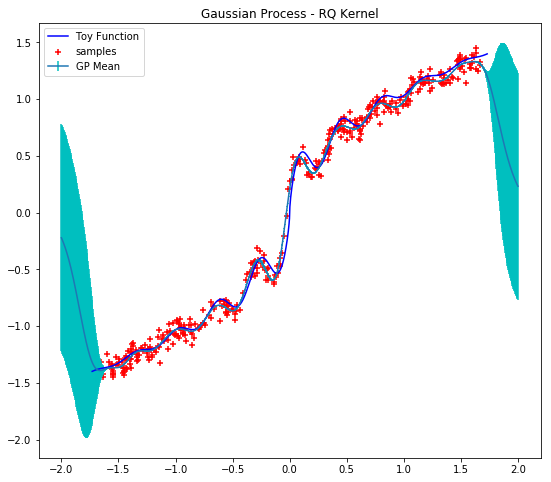

In [273]:
toykNN_y1, toyKNN_error = run_kNN(train_data_toy, test_data_toy, 1)
toykNN_y2, toyKNN_error2 = run_kNN(train_data_toy, test_data_toy, toy_bestK)

toylinreg_y , toylinreg_error = run_reg_lin_regression(train_data_toy, test_data_toy, delta = 0)

toy_forest1 = build_forest(train_x.reshape(400,1),train_y,20,1,int(500 * 0.25),20)
toy_forest2 = build_forest(train_x.reshape(400,1),train_y,toy_best_ntrees,1,int(best_size*train_x.shape[0]),toy_best_Depth)
toyforest_y1, toyforest_error1 = predict_forest(toy_forest1, test_x.reshape(100,1))
toyforest_y2, toyforest_error2 = predict_forest(toy_forest2, test_x.reshape(100,1))


toy_cov1 = squaredExpKernel_Quick(train_x.reshape(400,1),train_x, toy_sigma_SE , 0.1)
toy_cov2 = rationalQuadraticKernel_Quick(train_x.reshape(400,1), toy_alpha_RQ, toy_sigma_RQ , 0.1)
x_pred = np.linspace(-2, 2, 1000)
toyGuassian1_graph = GuassianProccessPredict(toy_cov1, train_x,train_y, x_pred.reshape((1000,1)) , 0.05, squaredExpKernel , toy_sigma_SE , 0.1 )
toyGuassian1_test = GuassianProccessPredict(toy_cov1, train_x,train_y, test_data_toy[:,:-1] , 0.05, squaredExpKernel , toy_sigma_SE , 0.1 )
SE_error = least_squares_error(test_data_toy[:,-1],toyGuassian1_test[:,0])

toyGuassian2_graph = GuassianProccessPredict(toy_cov2, train_x,train_y, x_pred.reshape((1000,1)) , 0.05, rationalQuadraticKernel ,toy_alpha_RQ, toy_sigma_RQ , 0.1 )
toyGuassian2_test = GuassianProccessPredict(toy_cov2, train_x,train_y, test_data_toy[:,:-1] , 0.05, rationalQuadraticKernel ,toy_alpha_RQ, toy_sigma_RQ , 0.1 )
RQ_error = least_squares_error(test_data_toy[:,-1],toyGuassian2_test[:,0])

print("KNN Method Before Optimization, Test Error = ", toyKNN_error)
print("KNN Method After Optimization, Test Error = ", toyKNN_error2)
fig=plt.figure(figsize=(9, 8))
plt.scatter(test_x,test_y,c='b',marker='.' ,label = 'Test Data')
plt.scatter(test_x,toykNN_y1,c='r',marker='.',label = 'Test Prediction before Optim')
plt.scatter(test_x,toykNN_y2,c='c',marker='.',label = 'Test Prediction after Optim')
plt.legend(loc='upper left')
plt.title("k Nearest Neighbors")
plt.show()

print("Linear Regression, Test Error = ", toylinreg_error)
fig=plt.figure(figsize=(9, 8))
plt.scatter(test_x,test_y,c='b',marker='.',label = 'Test Data' )
plt.scatter(test_x,toylinreg_y,c='r',marker='.',label = 'Test Prediction' )
plt.legend(loc='upper left')
plt.title("Linear Regression")
plt.show()

print("Regression Forest Method Before Optimization, Test Error = ", toyforest_error1)
print("Regression Forest Method After Optimization, Test Error = ", toyforest_error2)
fig=plt.figure(figsize=(9, 8))
plt.scatter(test_x,test_y,c='b',marker='.',label = 'Test Data' )
plt.scatter(test_x,toyforest_y1,c='r',marker='.',label = 'Test Prediction before Optim' )
plt.scatter(test_x,toyforest_y2,c='c',marker='.',label = 'Test Prediction after Optim' )
plt.legend(loc='upper left')
plt.title("Regression Forest")
plt.show()


#plt.scatter(test_x,,c='r',marker='.' )
print("Gaussian Process with SE Kernel, Test Error = ",SE_error)
fig=plt.figure(figsize=(9, 8))
plt.errorbar(x_pred,toyGuassian1_y[:,0], yerr=toyGuassian_y[:,1], capsize=0, ecolor='c',label = 'GP Mean')
plt.scatter(train_x[0:400],train_y[0:400],c='r',marker='+',label = 'samples' )
plt.plot(x_pred_norm,y_pred_norm, c='b', label = 'Toy Function')
plt.legend(loc='upper left')
plt.title("Gaussian Process - SE Kernel")
plt.show()

print("Gaussian Process with RQ Kernel, Test Error = ",RQ_error)
fig=plt.figure(figsize=(9, 8))
plt.errorbar(x_pred,toyGuassian2_y[:,0], yerr=toyGuassian_y[:,1], capsize=0, ecolor='c',label = 'GP Mean')
plt.scatter(train_x[0:400],train_y[0:400],c='r',marker='+',label = 'samples' )
plt.plot(x_pred_norm,y_pred_norm, c='b', label = 'Toy Function')
plt.legend(loc='upper left')
plt.title("Gaussian Process - RQ Kernel")
plt.show()